In [30]:
# Extensions
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
# Imports
import torch
import pandas as pd
import numpy as np
import seqdatasets
import seqdata as sd
import xarray as xr

In [2]:
from eugene import preprocess as pp
from eugene.models.zoo import DeepBind, DeepSTARR

In [3]:
# Configure
sdata = seqdatasets.jores21()
pp.ohe_seqs_sdata(sdata)
#pp.train_test_split_sdata(sdata)
#sdata["target"] = xr.concat([sdata["label_0"], sdata["label_1"], sdata["label_2"]], dim="_targets").transpose("_sequence", "_targets").load()
#sdata["target"] = xr.concat([sdata["activity_0"], sdata["activity_1"], sdata["activity_2"]], dim="_targets").transpose("_sequence", "_targets").load()
sdata["seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
sdata["target"] = sdata["enrichment"].load()

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.


0it [00:00, ?it/s]

72158it [00:15, 4571.88it/s]


In [4]:
train_mask = np.where(sdata["set"] == "train")[0]
train_sdata = sdata.isel(_sequence=train_mask)
val_sdata = sdata.isel(_sequence=~train_mask)

In [5]:
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["seq", "target"],
    transforms={"seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["seq", "target"],
    transforms={"seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

# `SequenceModule`

In [6]:
from eugene.models import SequenceModule

In [7]:
batch = next(iter(train_dataloader))
seq = batch["seq"]
target = batch["target"]

In [8]:
seq.shape

torch.Size([128, 4, 170])

In [9]:
arch = DeepSTARR(
    input_len=170,
    output_dim=1
)

In [10]:
arch.conv1d_tower(seq).shape

torch.Size([128, 120, 166])

In [11]:
arch.conv1d_tower.out_channels * arch.conv1d_tower.output_len

19920

In [12]:
arch(seq).shape, target.shape

(torch.Size([128, 1]), torch.Size([128]))

In [13]:
model = SequenceModule(
    arch=arch,
    task="regression",
    arch_name="DeepSTARR",
    model_name="random1000_deepbind",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
    #metric_kwargs={"num_classes": 3, "task": "multiclass"}
)

In [14]:
from eugene.models.base._metrics import calculate_metric

In [15]:
model.train_metric

R2Score()

In [16]:
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    outs=model(seq),
    y=target
)

In [18]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger

In [19]:
callbacks = []

In [21]:
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests", 
    name="jores21_deepstarr",
    version="0.0.7"
)

In [22]:
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
    save_top_k=3, 
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)

In [23]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)

In [24]:
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())

In [25]:
trainer = Trainer(
    max_epochs=10, 
    logger=logger, 
    devices=1, 
    accelerator="auto",
    callbacks=callbacks, 
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(


In [52]:
from eugene import plot as pl

Matplotlib is building the font cache; this may take a moment.


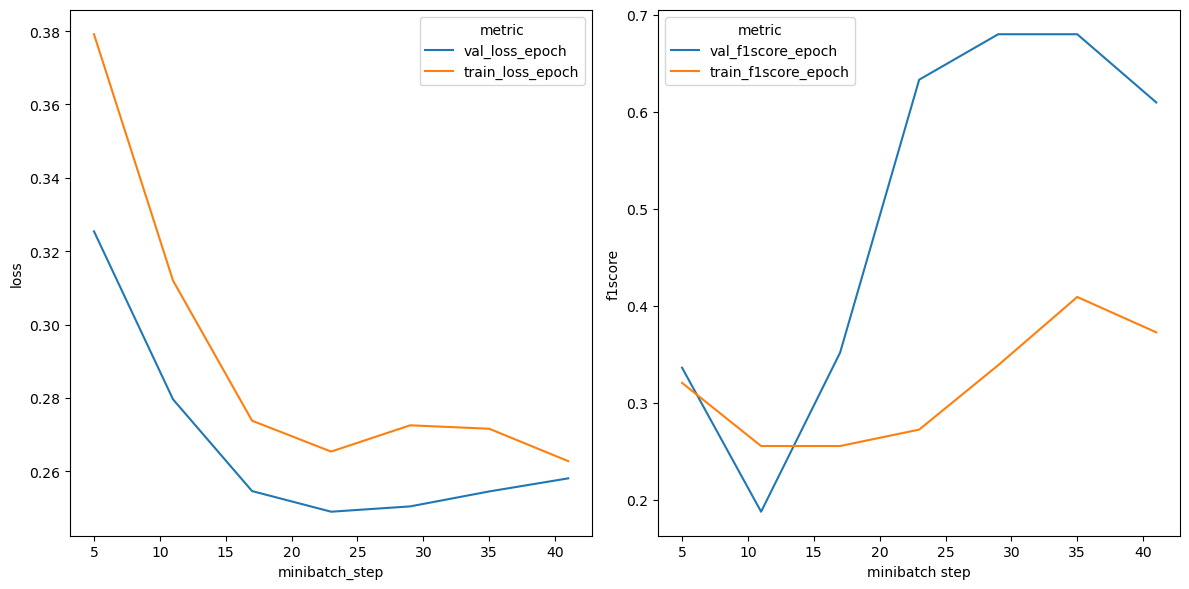

In [87]:
pl.training_summary("/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests/jores21_deepstarr/0.0.7", metric="f1score")

In [12]:
import os
from os import PathLike
from typing import List, Union

import numpy as np
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from torch.utils.data import DataLoader, Dataset

from eugene import settings

# Note that CSVLogger is currently hanging training with SequenceModule right now
# Note that if you use wandb logger, it comes with a few extra steps. Show a notebook for this
LOGGER_REGISTRY = {
    #"csv": CSVLogger,
    "tensorboard": TensorBoardLogger,
    #"wandb": WandbLogger,
}

def fit(
    model: LightningModule,
    sdata = None,
    target_keys: Union[str, List[str]] = None,
    train_key: str = "train_val",
    epochs: int = 10,
    gpus: int = None,
    batch_size: int = None,
    num_workers: int = None,
    logger: str = "csv",
    log_dir: PathLike = None,
    name: str = None,
    version: str = None,
    train_dataset: Dataset = None,
    val_dataset: Dataset = None,
    train_dataloader: DataLoader = None,
    val_dataloader: DataLoader = None,
    seq_transforms: List[str] = None,
    transform_kwargs: dict = {},
    early_stopping_metric: str = "val_loss_epoch",
    drop_last=True,
    early_stopping_callback: bool = True,
    early_stopping_patience=5,
    early_stopping_verbose=False,
    model_checkpoint_k = 1,
    model_checkpoint_monitor: str ="val_loss_epoch",
    seed: int = None,
    return_trainer: bool = False,
    **kwargs
):
    """
    Train the model using PyTorch Lightning.

    Parameters
    ----------
    model : BaseModel
        The model to train.
    sdata : SeqData
        The SeqData object to train on.
    target_keys : str or list of str
        The target keys in sdata's seqs_annot attribute to train on.
    train_key : str
        The key in sdata's seqs_annot attribute to split into train and validation set
    epochs : int
        The number of epochs to train for.
    gpus : int
        The number of gpus to use. EUGENe will automatically use all available gpus if available.
    batch_size : int
        The batch size to use.
    num_workers : int
        The number of workers to use for the dataloader.
    log_dir : PathLike
        The directory to save the logs to.
    name : str
        The name of the experiment.
    version : str
        The version of the experiment.
    train_dataset :Dataset 
        The training dataset to use. If None, will be created from sdata.
    val_dataset :Dataset 
        The validation dataset to use. If None, will be created from sdata.
    train_dataloader : DataLoader
        The training dataloader to use. If None, will be created from train_dataset.
    val_dataloader : DataLoader
        The validation dataloader to use. If None, will be created from val_dataset.
    seq_transforms : list of str
        The sequence transforms to apply to the data.
    transform_kwargs : dict
        The keyword arguments to pass to the sequence transforms.
    early_stopping_metric : str
        The metric to use for early stopping.
    early_stopping_patience : int
        The number of epochs to wait before stopping.
    early_stopping_verbose : bool
        Whether to print early stopping messages.
    seed : int
        The seed to use for reproducibility.
    verbosity : int
        The verbosity level.
    kwargs : dict
        Additional keyword arguments to pass to the PL Trainer.

    Returns
    -------
    trainer : Trainer
        The PyTorch Lightning Trainer object.
    """
    # Set training parameters
    gpus = gpus if gpus is not None else settings.gpus
    batch_size = batch_size if batch_size is not None else settings.batch_size
    num_workers = num_workers if num_workers is not None else settings.dl_num_workers
    log_dir = log_dir if log_dir is not None else settings.logging_dir
    model_name = model.__class__.__name__
    name = name if name is not None else model_name
    seed_everything(seed, workers=True) if seed is not None else print("No seed set")

    # Set-up dataloaders
    if train_dataloader is not None:
        assert val_dataloader is not None
    elif train_dataset is not None:
        assert val_dataset is not None
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
    elif sdata is not None:
        if target_keys is not None:
            targs = sdata.seqs_annot[target_keys].values
            if len(targs.shape) == 1:
                nan_mask = np.isnan(targs)
            else:
                nan_mask = np.any(np.isnan(targs), axis=1)
            print(f"Dropping {nan_mask.sum()} sequences with NaN targets.")
            sdata = sdata[~nan_mask]  
        train_idx = np.where(sdata.seqs_annot[train_key] == True)[0]
        train_dataset = sdata[train_idx].to_dataset(
            target_keys=target_keys,
            seq_transforms=seq_transforms,
            transform_kwargs=transform_kwargs,
        )
        train_dataloader = train_dataset.to_dataloader(
            batch_size=batch_size, 
            num_workers=num_workers, 
            shuffle=True,
            drop_last=drop_last
        )
        val_idx = np.where(sdata.seqs_annot[train_key] == False)[0]
        val_dataset = sdata[val_idx].to_dataset(
            target_keys=target_keys,
            seq_transforms=seq_transforms,
            transform_kwargs=transform_kwargs,
        )
        val_dataloader = val_dataset.to_dataloader(
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=drop_last
        )
    else:
        raise ValueError("No data provided to train on.")
    
    # Set-up callbacks
    logger = LOGGER_REGISTRY[logger](save_dir=log_dir, name=name, version=version)
    callbacks = []
    if model_checkpoint_monitor is not None:
        model_checkpoint_callback = ModelCheckpoint(
            dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
            save_top_k=model_checkpoint_k, 
            monitor=model_checkpoint_monitor
        )
        callbacks.append(model_checkpoint_callback)
    if early_stopping_metric is not None:
        early_stopping_callback = EarlyStopping(
            monitor=early_stopping_metric,
            patience=early_stopping_patience,
            mode="min",
            verbose=early_stopping_verbose,
        )
        callbacks.append(early_stopping_callback)
    if model.scheduler is not None:
        callbacks.append(LearningRateMonitor())
    trainer = Trainer(
        max_epochs=epochs, 
        logger=logger, 
        devices=gpus, 
        accelerator="auto",
        callbacks=callbacks, 
        **kwargs
    )
    trainer.fit(
        model, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader
    )
    if return_trainer:
        return trainer

# `ProfileModule`

# DONE

---

# Scratch